**Part 3: Testing**

# Libraries

In [ ]:
# drive
from google.colab import drive
drive.mount('/content/drive')

# utils library with functions
! cp drive/MyDrive/industrylab/Notebooks/utils.py ./utils.py
from utils import *

# generic
import pandas as pd
import numpy as np
import json
import os
import joblib

# graphics
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (13,7)
plt.rcParams["figure.figsize"] = (13,7)

# ml
import tensorflow as tf
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.random.seed(0)
tf.random.set_seed(0)

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/industrylab/"

# Load data

In [ ]:
# load files
data_tot = import_files(base_path, targets, prevs)

In [ ]:
# load scaler
scaler = get_scaler(base_path)

# Livello

In [ ]:
target = 'livello'

In [ ]:
def get_prev_offset_from_filename(f):
  x = f[(f.index('offset')+len('offset')):]
  offset = x[:x.index('_')]
  x = f[(f.index('prev')+len('prev')):]
  prev = x[:x.index('_')]
  return prev, offset

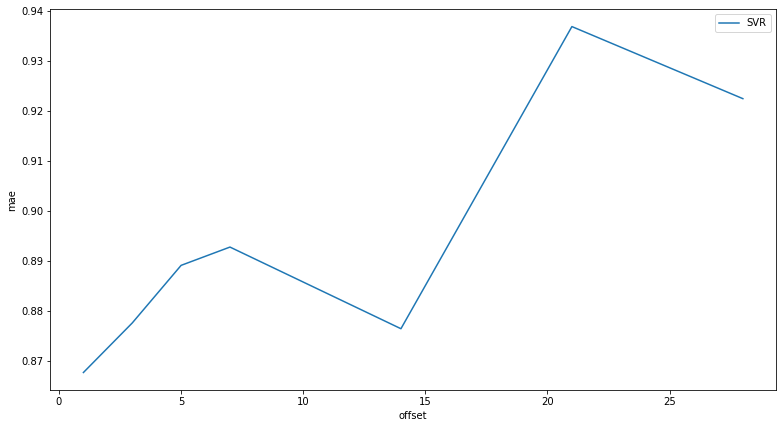

In [ ]:
tot_errors = []

tmp_path = base_path+'Models/svr/'
files = [tmp_path+f for f in os.listdir(tmp_path) if 'results' not in f and target in f]
for f in files:
  prev, offset = get_prev_offset_from_filename(f)

  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)
  
  model = joblib.load(base_path+'Models/svr/svr_offset'+str(offset)+'_prev'+str(prev)+'_'+target+'.joblib')

  y_pred = scaler[target].inverse_transform(model.predict(X_test).reshape(-1,1))
  y_true = scaler[target].inverse_transform(np.array(y_test).reshape(-1,1))
  mae = mean_absolute_error(y_true, y_pred)
  tot_errors.append(mae)

df = pd.DataFrame(np.array([tot_errors]).reshape(-1,1), columns=['mae'])
df['offset'] = offsets
sns.lineplot(data=df, x='offset', y='mae', label='SVR')

In [ ]:
df = df[['offset', 'mae']]
df.round(3)

,offset,mae
0,1,0.868
1,3,0.878
2,5,0.889
3,7,0.893
4,14,0.876
5,21,0.937
6,28,0.923


costruisco heatmap per ogni combinazione offset - prev, dei MAE sul test set

In [ ]:
rows = []

for offset in offsets:
  row = []
  for prev in prevs:
    # read files
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, prev, offset)

    # reshape
    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)

  
    model = joblib.load(base_path+'Models/svr/svr_offset'+str(offset)+'_prev'+str(prev)+'_'+target+'.joblib')


    # make predictions on test
    y_pred = scaler[target].inverse_transform(model.predict(X_test).reshape(-1,1))
    y_true = scaler[target].inverse_transform(np.array(y_test).reshape(-1,1))

    # calculate mae on test
    mae = mean_absolute_error(y_true, y_pred)

    row.append(mae)
  rows.append(row)

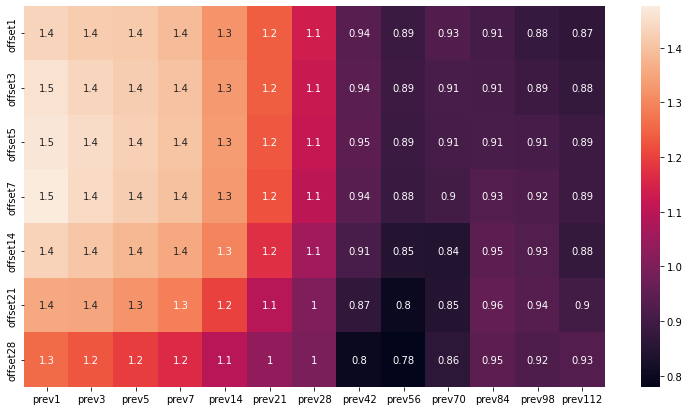

In [ ]:
index = ['offset'+str(o) for o in offsets]
cols = ['prev'+str(p) for p in prevs]
df = pd.DataFrame(rows, columns=cols, index=index)
df.to_csv(base_path+'Models/svr/svr_'+target+'_results_on_test.csv', index=False)
sns.heatmap(df, annot=True)

# Portata

In [ ]:
target = 'portata'

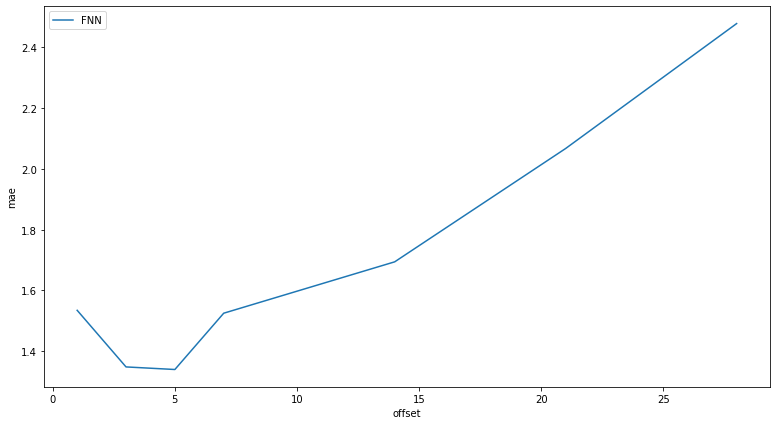

In [ ]:
with open(base_path+'Models/nn/nn_'+target+'_best_prevs.json', 'r') as f:
    best_prevs_dict = json.load(f)

tot_errors = []
for offset, best_prev in best_prevs_dict.items():
  
  model = keras.models.load_model(base_path+'Models/nn/model_'+target+'_offset'+str(offset))
  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(best_prev), int(offset))

  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)

  y_pred = scaler[target].inverse_transform(model.predict(X_test))
  y_true = scaler[target].inverse_transform(np.array(y_test).reshape(-1,1))
  mae = mean_absolute_error(y_true, y_pred)
  tot_errors.append(mae)

df = pd.DataFrame(np.array([tot_errors]).reshape(-1,1), columns=['mae'])
df['offset'] = offsets
sns.lineplot(data=df, x='offset', y='mae', label='FNN')

In [ ]:
df = df[['offset', 'mae']]
df.round(3)

,offset,mae
0,1,1.535
1,3,1.349
2,5,1.340
3,7,1.525
4,14,1.694
5,21,2.067
6,28,2.477


costruisco heatmap per ogni combinazione offset - prev, dei MAE sul test set

In [ ]:
rows = []
for offset in offsets:
  row = []
  for prev in prevs:

    model = keras.models.load_model(base_path+'Models/nn/model_'+target+'_offset'+str(offset)+'_prev'+str(prev))
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

    X_train = X_train.reshape(len(X_train),-1)
    X_val = X_val.reshape(len(X_val),-1)
    X_test = X_test.reshape(len(X_test),-1)


    y_pred = scaler[target].inverse_transform(model.predict(X_test))
    y_true = scaler[target].inverse_transform(np.array(y_test).reshape(-1,1))
    mae = mean_absolute_error(y_true, y_pred)

    row.append(mae)
  rows.append(row)

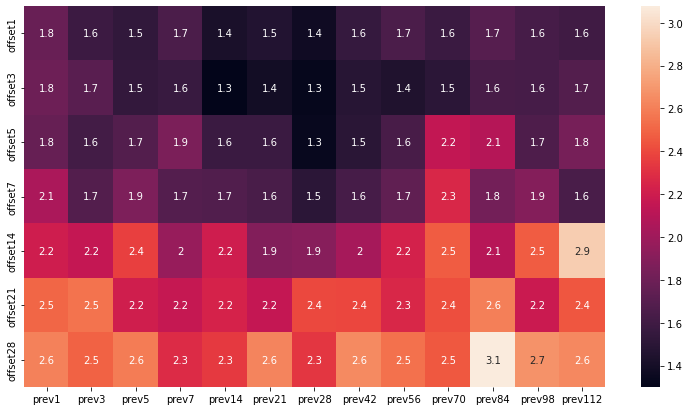

In [ ]:
index = ['offset'+str(o) for o in offsets]
cols = ['prev'+str(p) for p in prevs]
df = pd.DataFrame(rows, index=index, columns=cols)
df.to_csv(base_path+'Models/nn/nn_'+target+'_results_on_test.csv', index=False)
sns.heatmap(df, annot=True)

# XAI

solo per modelli SKlearn,  applico su best model SVR rispetto a target livello

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
target = 'livello'

In [ ]:
tmp_path = base_path+'Models/svr/'
files = [tmp_path+f for f in os.listdir(tmp_path) if 'results' not in f and target in f]

for f in files:
  prev, offset = get_prev_offset_from_filename(f)

  # read files
  X_train, X_val, X_test, y_train, y_val, y_test = get_data(data_tot, target, int(prev), int(offset))

  # reshape
  X_train = X_train.reshape(len(X_train),-1)
  X_val = X_val.reshape(len(X_val),-1)
  X_test = X_test.reshape(len(X_test),-1)


  model = joblib.load(base_path+'Models/svr/svr_offset'+str(offset)+'_prev'+str(prev)+'_'+target+'.joblib')

  importances = permutation_importance(model, X_test, y_test, n_repeats=3, scoring='neg_mean_absolute_error', random_state=123)

  FEAT = [feat+'_'+str(i) for i in range(int(prev)) for feat in ['p1', 'p2', 'p3', 'p4', 'p5', 't5', 'portata']]
  importances_df = pd.DataFrame({
    'feature': FEAT,
    'mean': importances['importances_mean'],
    'std': importances['importances_std']
  })

  
  importances_df.sort_values(by='mean', ascending=False, inplace=True)

  importances_df.to_csv(base_path+'Models/svr/xai/XAI_svr_offset'+str(offset)+'_prev'+str(prev)+'_'+target+'.csv', index=False)




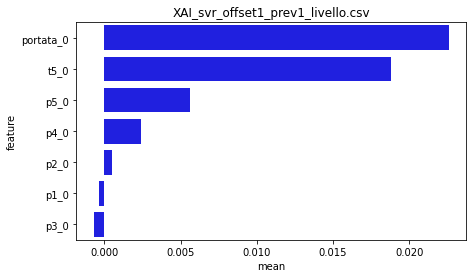

In [ ]:
for xai_file in os.listdir(base_path+'Models/svr/xai/'):
  plt.rcParams["figure.figsize"] = (7,4)
  importances_df = pd.read_csv(base_path+'Models/svr/xai/'+xai_file)
  sns.barplot(x='mean', y='feature', data=importances_df, color='blue');
  plt.title(xai_file);
  plt.show();
  break